# SOLO Coding Session

1. Feature Pyramid Network
2. MatrixNMS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple
from torch import Tensor

## Feature Pyramid Network

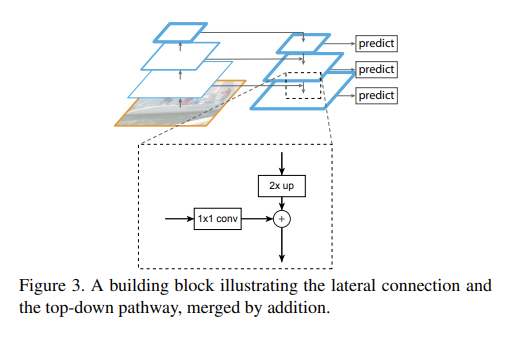

In this coding exercise, we will focus on implementing the top-down pathway of FPN (right side of Figure 3 above).

For each level, we have 2 convolution layers:
- One is the 1x1 convolution layer passing the original feature map defined in `inner_blocks`
- The other is a 3x3 convolution layer defined in `layer_blocks` which passes the summed feature map

We have in total 4 levels directly output from ResNet backbone. The final 'pool' level of FPN output (which is the coarsest) is done by downsampling the coarsest result from the convolutions. You can do it by using a 1x1 `MaxPooling` with step=2.

So in total, we will have 4 `Conv2d` layers for each block with the `kernel_size=1, stride=1` for `inner_blocks` and `kernel_size=3, padding=1, stride=1` for `layer_blocks`. There is a last Downsampling layer that we call `extra_blocks`.

One thing to note is that there are no activation functions in FPN. You only need to use `Conv2d`, `F.interpolate` and `+`.

Helpful resources:
- https://paperswithcode.com/method/fpn

In [2]:
# We will use the PyTorch ResNet FPN backbone
resnet_fpn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True).backbone

# This is the ground truth FPN that we want to build
resnet_fpn.cuda()
fpn_gt = resnet_fpn.fpn
weights = fpn_gt.state_dict()

# Return ordered dict of feature maps in channels (256, 512, 1024, 2048)
resnet = resnet_fpn.body

# Visualize the ground truth FPN layers
fpn_gt

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0-3): 4 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelMaxPool()
)

In [ ]:
class FPN(nn.Module):
    def __init__(self):
        super().__init__()

        self.inner_blocks = nn.ModuleList([
            ### YOUR IMPLEMENTATION HERE (around 4 lines of code) ###
        ])

        self.layer_blocks = nn.ModuleList([
            ### YOUR IMPLEMENTATION HERE (around 4 lines of code) ###
        ])

        self.extra_blocks =
        ### YOUR IMPLEMENTATION HERE (1 line of code) ###


    def load_from_state_dict(
        self,
        state_dict,
    ):
        """
        This is a helper function used to evaluate your implementation
        """
        num_blocks = len(self.inner_blocks)
        for block in ["inner_blocks", "layer_blocks"]:
            for i in range(num_blocks):
                for type in ["weight", "bias"]:
                    old_key = f"{block}.{i}.0.{type}"
                    new_key = f"{block}.{i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)
        self.load_state_dict(state_dict)


    def forward(self, x: Dict[str, torch.Tensor]):
        """
        Coding Exercise: Return the feature map layers in top-down pathway of FPN

        Steps:
            0. Refer to Figure 3 at the top of this notebook
            1. As we go down the top-down path (right side of Figure 3), we upsample the previous top-down layer using interpolation ('nearest')
            2. We apply 1x1 convolution to the corresponding feature map in the bottom-up pathway (left side of Figure 3)
            3. Then we add the feature maps from steps 1 and 2 element-wise
            4. We apply a 3x3 convolution to all merged layers. This filter reduces the aliasing effect when merged with the upsampled layer

        Use self.inner_blocks, self.layer_blocks, and self.extra_blocks. You will update and return an ordered dict of 'names' and 'results'
        """
        names = list(x.keys())
        x = list(x.values())

        for i in range(len(x)):
            print("layer {} shape {}".format(i, x[i].shape))

        # 'results' will be your list of feature maps in the top-down pathway
        # We've added the first feature map for you
        results = []
        last_inner = self.inner_blocks[-1](x[-1])
        results.append(self.layer_blocks[-1](last_inner))

        ### YOUR IMPLEMENTATION HERE (around 10 lines of code) ###

        # Convert it back to an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])
        return out

In [ ]:
# Let's test your implementation!
# Make sure your FPN has the exact same outputs as the PyTorch FPN

fpn = FPN()
fpn.cuda()
fpn.load_from_state_dict(weights) # Weights are from PyTorch FPN

img = torch.rand(3, 3, 800, 1088).cuda()

res1 = resnet_fpn(img)
res2 = fpn(resnet(img))

is_equal = True
for i in ['0', '1', '2', '3', 'pool']:
    is_equal = is_equal and res1[i].shape == res2[i].shape

is_equal # This should return True

layer 0 shape torch.Size([3, 256, 200, 272])
layer 1 shape torch.Size([3, 512, 100, 136])
layer 2 shape torch.Size([3, 1024, 50, 68])
layer 3 shape torch.Size([3, 2048, 25, 34])


True

## MatrixNMS

Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score.

MatrixNMS is used in SOLOv2. Read Section 2.2 of the SOLOv2 paper for the implementation: https://arxiv.org/pdf/2003.10152.pdf

We added 3 bugs (3 different lines of code) to the MatrixNMS function below.

In [ ]:
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    """
    Inputs:
        sorted_scores: mask scores in descending order (N)
        sorted_masks: binary masks (N x H x W)
        method: ’linear’ or ’gauss’
        gauss_sigma: std in gaussian method
    """
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)

    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T
    ious = (intersection / union).triu(diagonal=1)

    ious_cmin = ious.min(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 + ious_cmin ** 2) / gauss_sigma)
    else:
        decay = (ious) / (ious_cmin)

    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [ ]:
# Let's check your debugging skills!
# After the code below, the correct result should be:
# [0.9500, 0.8500, 0.4593, 0.5462, 0.4934, 0.2611, 0.2500, 0.1500, 0.0638, 0.0462]

preds = torch.tensor([[10,25,40,75],
                      [20,30,40,95],
                      [10,45,30,60],
                      [0,30,35,60],
                      [40,30,50,40],
                      [10,70,70,90],
                      [55,5,60,35],
                      [30,0,75,55],
                      [80,50,85,90],
                      [5,25,30,70]])
scores = torch.tensor([0.95, 0.1, 0.05, 0.65, 0.85, 0.55, 0.15, 0.5, 0.25, 0.45])
masks = torch.zeros((len(preds), 100, 100))
for i in range(len(preds)):
    masks[i, preds[i, 0]:preds[i, 2], preds[i, 1]:preds[i, 3]] = 1
sorted_score, indices = torch.sort(scores, descending=True)
sorted_masks = masks[indices]

result = MatrixNMS(sorted_masks, sorted_score)
print("Your result is ", result)

Your result is  tensor([0.9500, 0.8500, 0.5467, 0.5466, 0.4943, 0.3548, 0.2500, 0.1490, 0.0813,
        0.0453])
